In [30]:
from torchvision.models import vit_b_16
import torch.nn as nn
import torch

from surgeon_pytorch import Extract, get_nodes

from PIL import Image
import torchvision.transforms as transforms
import os


from captum.attr import LayerGradCam, LayerAttribution

In [36]:
NUM_CLASSES = 2
model = vit_b_16()
model.heads.head = nn.Linear(768, NUM_CLASSES)
model.load_state_dict(torch.load("logs/vit_waterbirds.pth", map_location=torch.device('cpu')))

model2 = vit_b_16()
model2.heads.head = nn.Linear(768, NUM_CLASSES)
model2.load_state_dict(torch.load("logs/dfr_model.pth", map_location=torch.device('cpu')))

C:\Users\elmop\AppData\Local\Temp\ipykernel_3744\354802881.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("logs/vit_waterbirds.pth", ma

<All keys matched successfully>

In [3]:
model.encoder.layers.encoder_layer_11.self_attention

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)

In [4]:
model_11_self_attention = Extract(model, node_out="encoder.layers.encoder_layer_11.self_attention")

In [31]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def tensorize(img_path):
    image = Image.open(img_path).convert('RGB')
    return preprocess(image)

In [6]:
img = tensorize('054.Blue_Grosbeak/Blue_Grosbeak_0038_37095.jpg').unsqueeze(0)


In [7]:
def attention_head_norm(model,img):
    model_11_ln_1 = Extract(model, node_out="encoder.layers.encoder_layer_11.ln_1")
    model_11_ln_1 = model_11_ln_1.eval()
    with torch.no_grad():
        out = model_11_ln_1(img)
        cls = out[:,0,:]
        cls_heads = cls.view(-1,12,64)
        head_norms = torch.norm(cls_heads, dim=2)
        
    return head_norms.squeeze(0).cpu().numpy()

In [8]:
a = attention_head_norm(model,img)

In [9]:
print(a)

[2.0453131 2.064281  1.8645698 2.2429101 2.0831938 1.995092  1.9534287
 2.6671143 1.8110955 2.233372  2.3647954 2.2962666]


In [10]:
def attention_head_norm2(model,img):
    model_11_ln_1 = Extract(model, node_out="encoder.layers.encoder_layer_11.mlp.4")
    model_11_ln_1 = model_11_ln_1.eval()
    with torch.no_grad():
        out = model_11_ln_1(img)
        cls = out[:,0,:]
        cls_heads = cls.view(-1,12,64)
        head_norms = torch.norm(cls_heads, dim=2)
        
    return head_norms.squeeze(0).cpu().numpy()

b = attention_head_norm2(model,img)


In [11]:
print(a)
print(b)
print(a-b)

[2.0453131 2.064281  1.8645698 2.2429101 2.0831938 1.995092  1.9534287
 2.6671143 1.8110955 2.233372  2.3647954 2.2962666]
[1.5229318 1.6818285 1.347488  1.5562341 1.2856089 1.4027098 1.3626838
 1.5598527 1.3324829 1.3388971 1.3817159 1.263748 ]
[0.5223813  0.3824525  0.51708174 0.686676   0.7975849  0.5923822
 0.590745   1.1072615  0.47861254 0.89447486 0.98307955 1.0325185 ]


In [12]:
model.encoder.layers[-1].self_attention

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)

In [13]:
type(img)

torch.Tensor

In [14]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [15]:
model_attention_to_head = Extract(model, node_in="encoder.layers.encoder_layer_11.self_attention", node_out="encoder.ln")

In [16]:
model_attention_to_head

GraphModule(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Module(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Module(
      (encoder_layer_0): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Module(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAtten

In [17]:
print(model_attention_to_head.summary)

{'input': ('x', 'encoder_layers_encoder_layer_11_self_attention'), 'output': encoder_ln}


In [18]:
pre_model = Extract(model, node_out="encoder.layers.encoder_layer_11.self_attention")

sub_model = nn.Sequential(
    model.encoder.layers.encoder_layer_11.ln_2,
    model.encoder.layers.encoder_layer_11.mlp,
    model.encoder.ln
)
sub_model.state_dict()

OrderedDict([('0.weight',
              tensor([0.5789, 0.5620, 0.5927, 0.5982, 0.5707, 0.5490, 0.5462, 0.4990, 0.5549,
                      0.5681, 0.5313, 0.5538, 0.5452, 0.5505, 0.5152, 0.6172, 0.5110, 0.5282,
                      0.5512, 0.5740, 0.5314, 0.5597, 0.5113, 0.5124, 0.5709, 0.5631, 0.5329,
                      0.5273, 0.5227, 0.3579, 0.5299, 0.5529, 0.5035, 0.5370, 0.5976, 0.5254,
                      0.5534, 0.5585, 0.5804, 0.5711, 0.5743, 0.5532, 0.6205, 0.6153, 0.5245,
                      0.5837, 0.5516, 0.5949, 0.5103, 0.5490, 0.5460, 0.5315, 0.5162, 0.5371,
                      0.5676, 0.5625, 0.5381, 0.5161, 0.5354, 0.5199, 0.5476, 0.5285, 0.1765,
                      0.5735, 0.5362, 0.5567, 0.5429, 0.5403, 0.5899, 0.5279, 0.5905, 0.5888,
                      0.5544, 0.5743, 0.5606, 0.5884, 0.5719, 0.5210, 0.6206, 0.5433, 0.4993,
                      0.5165, 0.5498, 0.5714, 0.5712, 0.5873, 0.5188, 0.5877, 0.4445, 0.5319,
                      0.5509, 0.56

In [19]:
#sub_model(pre_model(img))

In [20]:
m = Extract(model, node_out="encoder.ln")

In [21]:
from norms import Norms



In [22]:
norm = Norms(model)

torch.Size([196, 1, 64])
torch.Size([196, 1])
-1.4889348420865645e-08 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4889348e-08..1.0].


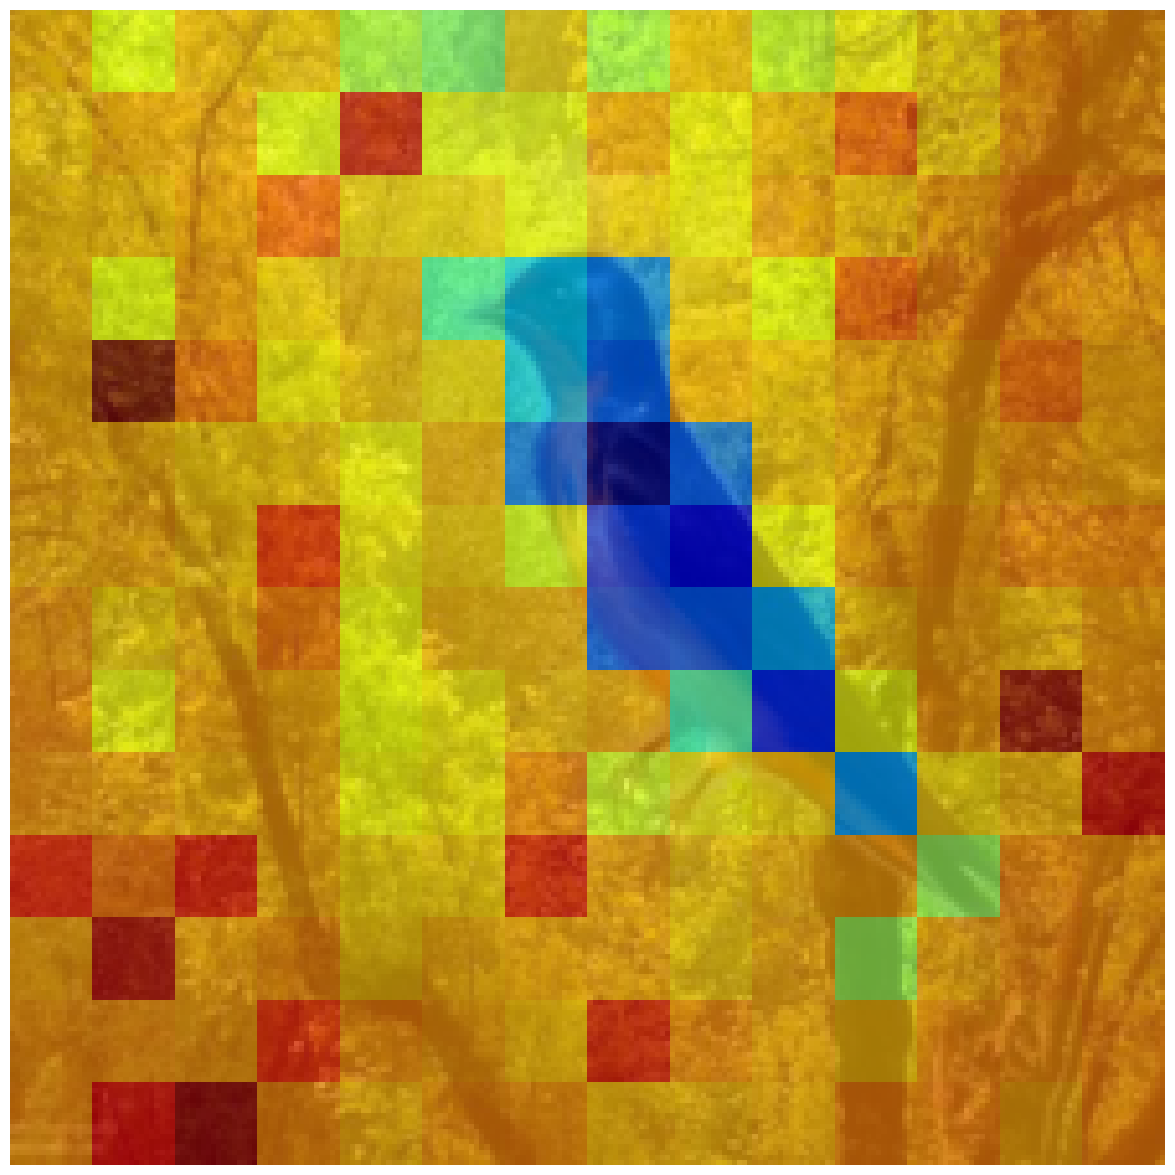

tensor([[[0.5254, 0.6807, 0.3411,  ..., 0.5499, 2.6152, 3.2260]],

        [[0.5612, 0.6082, 0.3595,  ..., 0.5759, 2.3823, 2.9216]],

        [[0.5218, 0.6648, 0.3458,  ..., 0.5321, 2.6477, 3.2605]],

        ...,

        [[0.5631, 0.7153, 0.3575,  ..., 0.5526, 2.6277, 3.2453]],

        [[0.5258, 0.6801, 0.3555,  ..., 0.5280, 2.6503, 3.2677]],

        [[0.5472, 0.6999, 0.3474,  ..., 0.5518, 2.6477, 3.2672]]])

In [23]:
norm.generate_and_visualize(tensorize('136.Barn_Swallow/Barn_Swallow_0047_130016.jpg'))


torch.Size([196, 1, 64])
torch.Size([196, 64])


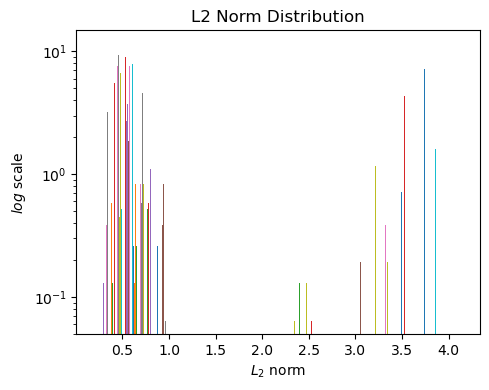

In [24]:
norm.plot_l2_norm_distribution_single(tensorize('001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'))

In [38]:
folder_path = 'notebooks/data/001.Black_footed_Albatross'

for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    input_tensor = tensorize(image_path).unsqueeze(0)
    with torch.no_grad():
                output1 = model(input_tensor)
                prediction1 = torch.argmax(output1, dim=1).item()
                
                output2 = model2(input_tensor)
                prediction2 = torch.argmax(output2, dim=1).item()
    print(filename, prediction1, prediction2)
            


Black_Footed_Albatross_0001_796111.jpg 0 1
Black_Footed_Albatross_0002_55.jpg 1 1
Black_Footed_Albatross_0003_796136.jpg 1 1
Black_Footed_Albatross_0005_796090.jpg 0 0
Black_Footed_Albatross_0006_796065.jpg 1 1
Black_Footed_Albatross_0007_796138.jpg 1 1
Black_Footed_Albatross_0008_796083.jpg 1 1
Black_Footed_Albatross_0009_34.jpg 1 1
Black_Footed_Albatross_0010_796097.jpg 1 1
Black_Footed_Albatross_0014_89.jpg 1 1
Black_Footed_Albatross_0016_796067.jpg 1 1
Black_Footed_Albatross_0017_796098.jpg 1 1
Black_Footed_Albatross_0019_796104.jpg 1 1
Black_Footed_Albatross_0023_796059.jpg 1 1
Black_Footed_Albatross_0024_796089.jpg 1 1
Black_Footed_Albatross_0025_796057.jpg 1 1
Black_Footed_Albatross_0026_796095.jpg 0 1
Black_Footed_Albatross_0031_100.jpg 1 1
Black_Footed_Albatross_0032_796115.jpg 1 1
Black_Footed_Albatross_0033_796086.jpg 1 1
Black_Footed_Albatross_0035_796140.jpg 1 0
Black_Footed_Albatross_0036_796127.jpg 1 1
Black_Footed_Albatross_0037_796120.jpg 1 1
Black_Footed_Albatross_003

KeyboardInterrupt: 